# Notebook Setup (Import and Initialization)

In [1]:
import torchvision.models as models
import torch
import torch.nn as nn
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from jupyterthemes import jtplot
from importlib import reload

In [2]:
from torchvision import transforms
from PIL import Image
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

# Image Setup

## Helper Functions

In [3]:
def squareCrop(x, squareDim):
    left = (x.size[0]-squareDim)/2
    upper = (x.size[1]-squareDim)/2
    right = (x.size[0] + squareDim)/2
    lower = (x.size[1] + squareDim)/2
    return x.crop(box = (left, upper, right, lower))

In [4]:
def resize(x, squareDim):
    width, height = x.size
    scale = squareDim/min(width, height)
    return x.resize((int(scale * width), int(scale * height)), resample = Image.LANCZOS)

In [5]:
def getImages(path, fileEnding, num):
    images = []
    for i in range(num):
        fp = Image.open(path + str(i) + fileEnding)
        fp.load() #to close file
        images.append(fp)

    minWidth = min(images, key = lambda x: x.size[0]).size[0]
    minHeight = min(images, key = lambda x: x.size[1]).size[1]
    squareDim = min(minWidth, minHeight)

    print(squareDim,"x",squareDim)

    cropfn = lambda x: x.crop(box = ((x.size[0]-squareDim)/2,(x.size[1]-squareDim)/2,squareDim,squareDim))
    for i in range(len(images)):
        images[i] = squareCrop(resize(images[i],squareDim), squareDim)#.convert('LA')
    return images

In [6]:
from PIL import Image
dogPath = "../Images/randDogSet/img"
buildingPath = "../Images/randBuildingSet/img"
fileEnding = ".jpg"
num = 230

dogImages = getImages(dogPath, fileEnding, num)
buildingImages = getImages(buildingPath, fileEnding, num)

126 x 126
131 x 131


## Images in the data set

In [7]:
def displayImages(images):
    i = 1
    reload(plt)
    %matplotlib inline
    plt.figure(figsize=(20,20))
    for im in images:
        ax = plt.subplot(23,10,i) #can change
        ax.imshow(np.asarray(im))
        ax.axis('off') 
        i += 1

## Dog Images

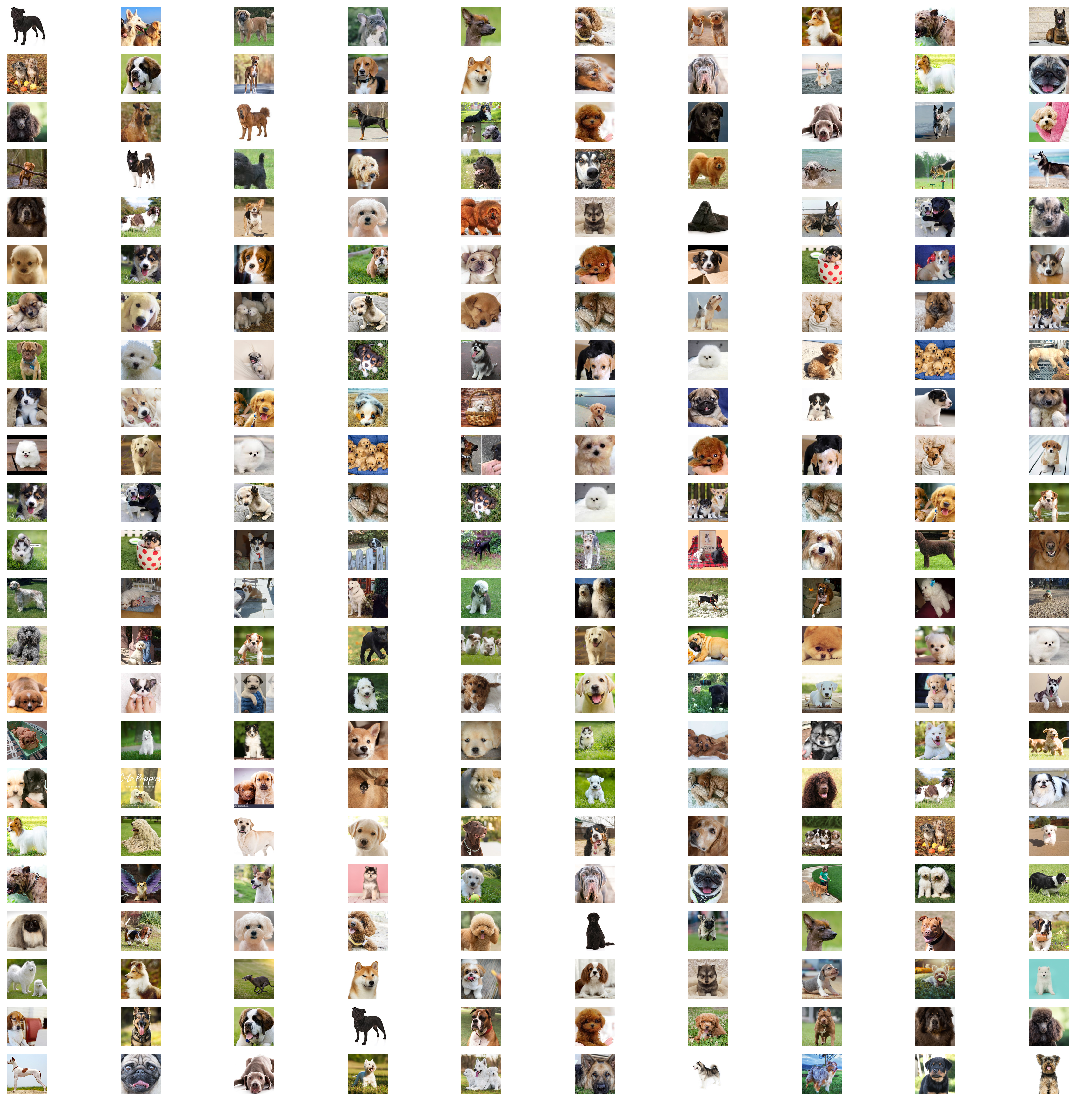

In [8]:
displayImages(dogImages)

## Building Images

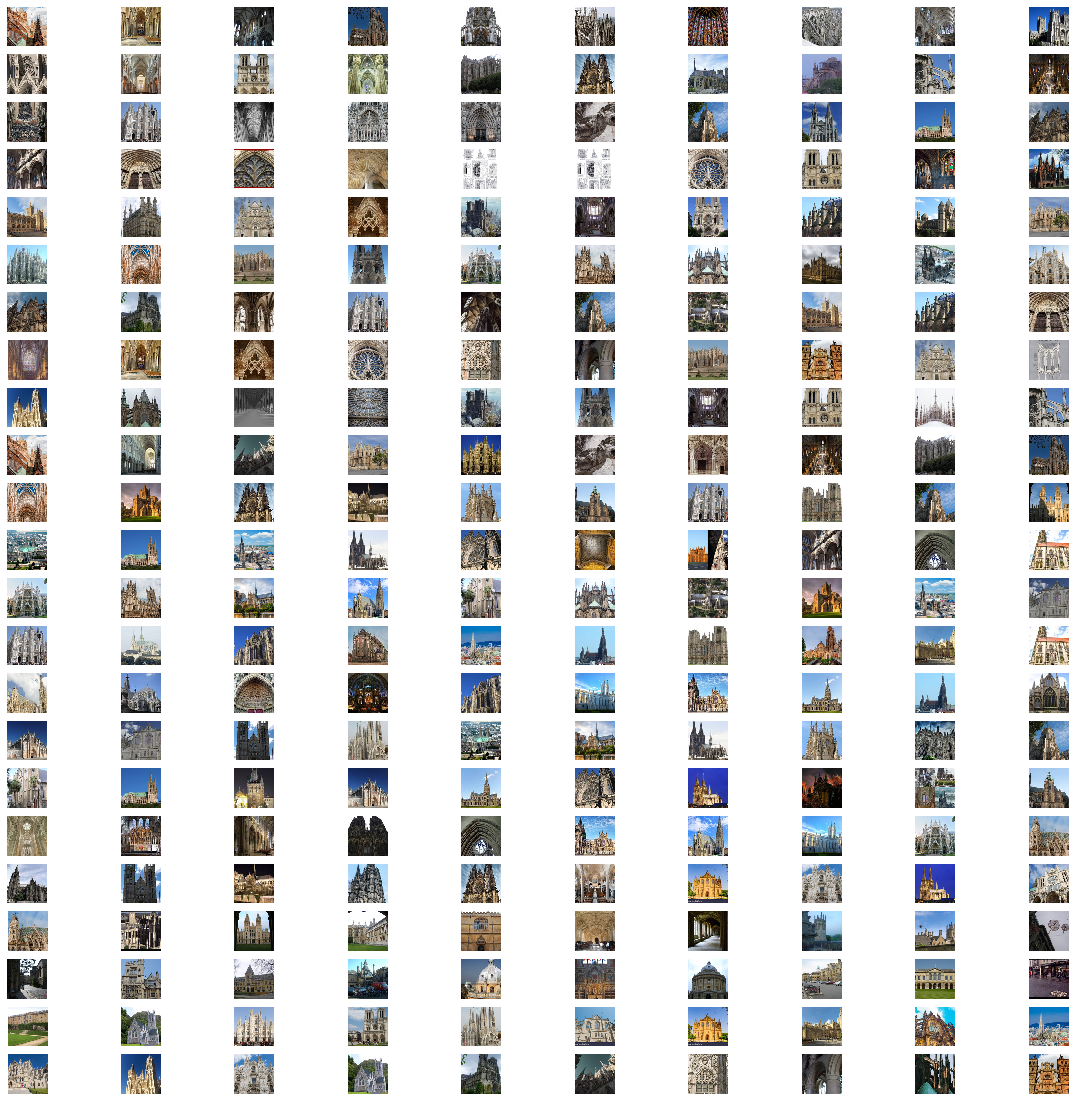

In [9]:
displayImages(buildingImages)

In [10]:
batch_t = []
i = 0
for img in dogImages + buildingImages:
    img_t = transform(img)
    batch_t.append(torch.unsqueeze(img_t, 0)) # batch_t is set of transformed image

# AlexNet Setup

In [11]:
alexnet = models.alexnet(pretrained = True)
alexnet.eval() # change alexnet model to eval mode
model = models.alexnet(pretrained=True)

In [12]:
out = []
for i in range(len(batch_t)):
    out.append(alexnet(batch_t[i]))
print(out[0].shape)
print(out[-1].shape)

torch.Size([1, 1000])
torch.Size([1, 1000])


In [13]:
i = 0
j = 0
weights = []
for child in model.children():
    print("child", i,":")
    if isinstance(child, nn.AdaptiveAvgPool2d):
        print("\t" + str(child))
    else:
        for param in child:
            print("\tLayer", j ,":", param)
            instance = isinstance(param, nn.ReLU) or isinstance(param, nn.MaxPool2d) or isinstance(param, nn.Dropout)
            if not instance:
                weights.append(param.weight)
            j += 1
    i += 1
# need to pick layer to read out the features from passing an image through the network 

child 0 :
	Layer 0 : Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
	Layer 1 : ReLU(inplace=True)
	Layer 2 : MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
	Layer 3 : Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
	Layer 4 : ReLU(inplace=True)
	Layer 5 : MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
	Layer 6 : Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
	Layer 7 : ReLU(inplace=True)
	Layer 8 : Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
	Layer 9 : ReLU(inplace=True)
	Layer 10 : Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
	Layer 11 : ReLU(inplace=True)
	Layer 12 : MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
child 1 :
	AdaptiveAvgPool2d(output_size=(6, 6))
child 2 :
	Layer 13 : Dropout(p=0.5, inplace=False)
	Layer 14 : Linear(in_features=9216, out_features=4096, bias=True)
	Layer 15 : ReLU(i

# Truncation of neural net layers

In [14]:
l = list(model.children())
layerNum = 10 #layer starts from 0
delete = len(l[0]) - layerNum -1 #number of truncating layers from the model
print("Layer:", layerNum)
print("Deleted", delete)
nn_trunc = nn.Sequential(*l[0][:len(l[0])-delete])
nn_trunc.eval()

Layer: 10
Deleted 2


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

## Output of passing image to model

In [15]:
out = []
for i in range(2*num):
    out.append(nn_trunc(batch_t[i]))
print(out[0].shape)
print(out[-1].shape)

torch.Size([1, 256, 13, 13])
torch.Size([1, 256, 13, 13])


## Reshaping output to 2 dims

In [16]:
arr = []
for i in range(2 * num):
    arr.append(out[i].view(1, out[i].shape[0]*out[i].shape[1]*out[i].shape[2]*out[i].shape[3]))

## Convert to numpy matrix

In [17]:
import numpy as np
x = arr[0].detach().numpy()
for nparr in arr[1:]:
    x = np.vstack([x, nparr.detach().numpy()])

# Dimension Reductionality

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## PCA

In [19]:
print(x.shape)
pca = PCA(n_components=50)
pca_result = pca.fit_transform(x)
print(pca_result.shape)

(460, 43264)
(460, 50)


## TSNE

In [20]:
tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result)
print(tsne_pca_results.shape)

(460, 3)


# Plotting Results from Dimensional Reductionality

In [21]:
dogs = tsne_pca_results[:num]
buildings = tsne_pca_results[num:]

In [163]:
reload(plt)
%matplotlib notebook
fig= plt.figure()
ax = fig.add_subplot(111, projection='3d')
x,y,z = dogs[:,0],dogs[:,1],dogs[:,2]
ax.scatter(x,y,z)

x,y,z = buildings[:,0],buildings[:,1],buildings[:,2]
ax.scatter(x,y,z)

<IPython.core.display.Javascript object>

# Saving Arrays to file

In [23]:
np.savetxt('./output/dog_layer' + str(layerNum) + '.txt', dogs, fmt='%d')
np.savetxt('./output/building_layer' + str(layerNum) + '.txt', buildings, fmt='%d')

# Example: Loading array from file

In [24]:
layerToLoad = 6
dogs = np.loadtxt('./output/dog_layer' + str(layerToLoad) + '.txt')
buildings = np.loadtxt('./output/building_layer' + str(layerToLoad) + '.txt')

# Layer Comparison

In [25]:
%matplotlib notebook
def loadPlot(layerToLoad):
    dogs = np.loadtxt('./output/dog_layer' + str(layerToLoad) + '.txt')
    buildings = np.loadtxt('./output/building_layer' + str(layerToLoad) + '.txt')

    fig= plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x,y,z = dogs[:,0],dogs[:,1],dogs[:,2]
    ax.scatter(x,y,z)

    x,y,z = buildings[:,0],buildings[:,1],buildings[:,2]
    ax.scatter(x,y,z)

In [161]:
import plotly.graph_objects as go
def plottlyLoadPlot(layerToLoad):
    dogs = np.loadtxt('./output/dog_layer' + str(layerToLoad) + '.txt')
    buildings = np.loadtxt('./output/building_layer' + str(layerToLoad) + '.txt')
    
    opacity = .5
    x,y,z = dogs[:,0],dogs[:,1],dogs[:,2]
    scatter1 = go.Scatter3d(x=x, y=y, z=z, mode='markers',
                            marker=dict(color='blue',opacity=opacity), name="Dogs")
    
    x,y,z = buildings[:,0],buildings[:,1],buildings[:,2]
    scatter2 = go.Scatter3d(x=x, y=y, z=z, mode='markers',
                            marker=dict(color='orange',opacity=opacity), name="Buildings")
    
    fig = go.Figure(data=[scatter1,scatter2])
    fig.show()

In [162]:
plottlyLoadPlot(3)
plottlyLoadPlot(6)
plottlyLoadPlot(8)
plottlyLoadPlot(10)

# Filtering Images

## Filter Helper Functions

In [28]:
def redFilter(arr):
    for pixels in arr:
        for pixel in pixels:
            pixel[1] = 0
            pixel[2] = 0

In [29]:
def greenFilter(arr):
    for pixels in arr:
        for pixel in pixels:
            pixel[0] = 0
            pixel[2] = 0

In [30]:
def blueFilter(arr):
    for pixels in arr:
        for pixel in pixels:
            pixel[0] = 0
            pixel[1] = 0

In [31]:
def grayscaleFilter(arr):
    for pixels in arr:
        for pixel in pixels:
            avg = sum(pixel)/3
            pixel[0] = avg
            pixel[1] = avg
            pixel[2] = avg

## Filtering all images

In [32]:
allImages = dogImages + buildingImages
rImages, gImages, bImages, gsImages = [], [],[], []
for image in allImages:
        rImage, gImage, bImage, gsImage = np.array(image), np.array(image), np.array(image), np.array(image)
        
        redFilter(rImage)
        greenFilter(gImage)
        blueFilter(bImage)
        grayscaleFilter(gsImage)
        
        rImages.append(rImage)
        bImages.append(gImage)
        gImages.append(bImage)
        gsImages.append(gsImage)

# Mapping to Pillow Image

In [33]:
from PIL import Image
picTransform = lambda x: Image.fromarray(x)
rImages = list(map(picTransform, rImages))
gImages = list(map(picTransform, gImages))
bImages = list(map(picTransform, bImages))
gsImages = list(map(picTransform, gsImages))

## Display output of Filtered Images

<IPython.core.display.Javascript object>


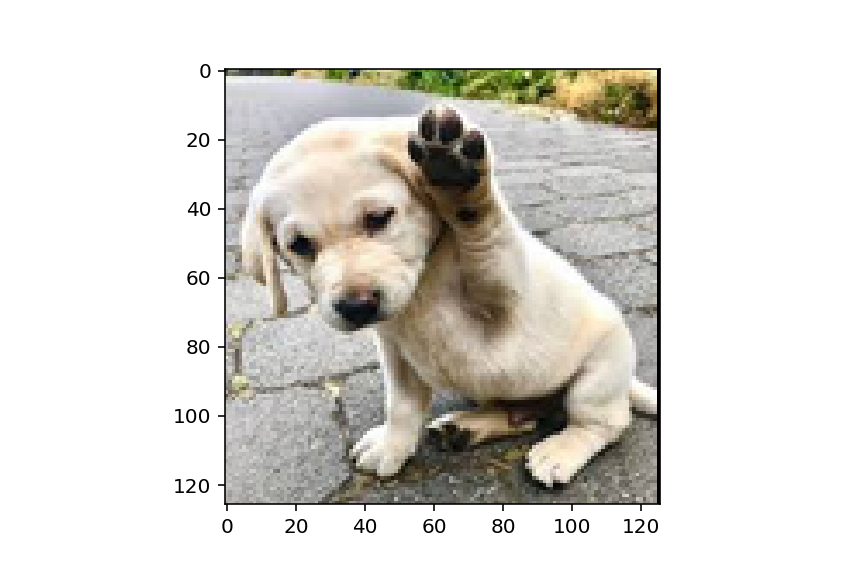

<IPython.core.display.Javascript object>


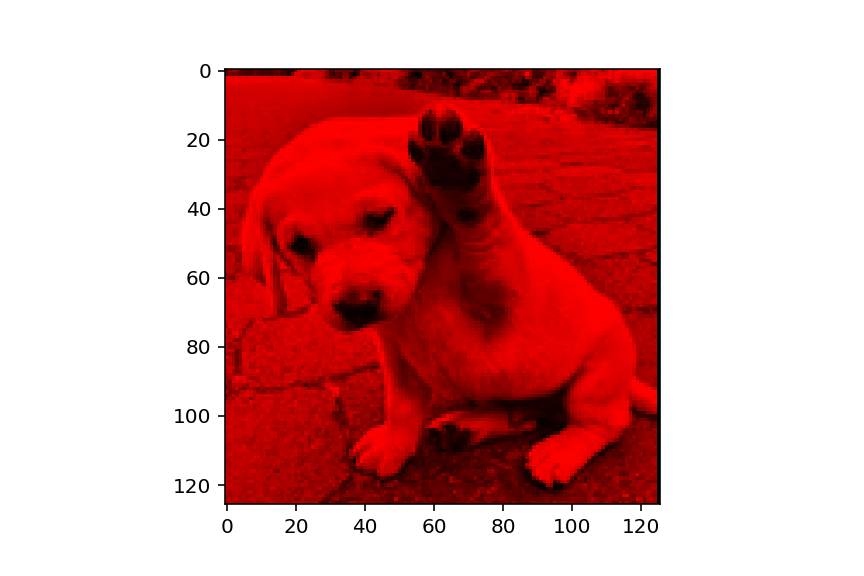

<IPython.core.display.Javascript object>


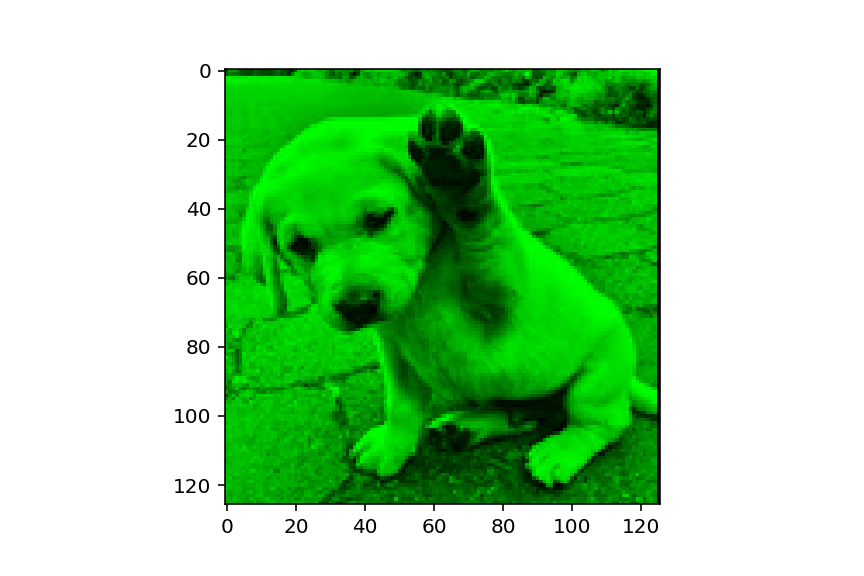

<IPython.core.display.Javascript object>


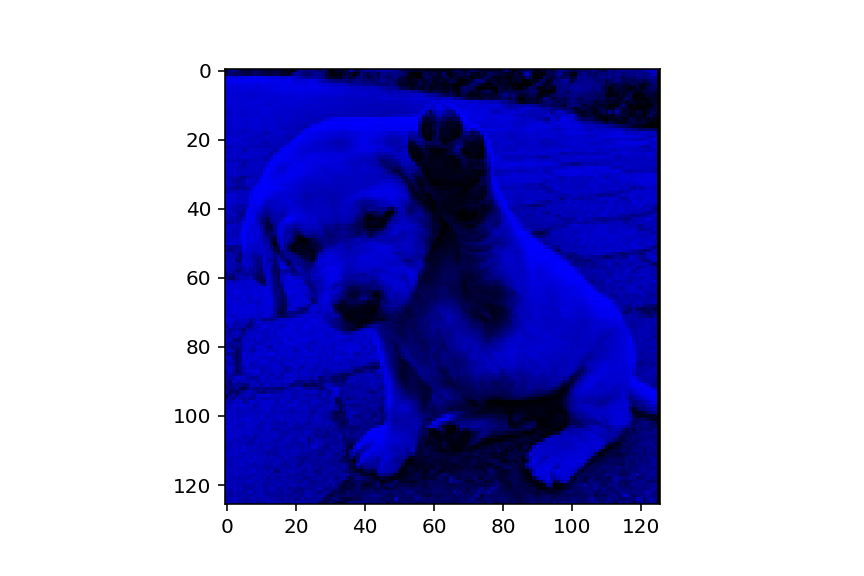

<IPython.core.display.Javascript object>


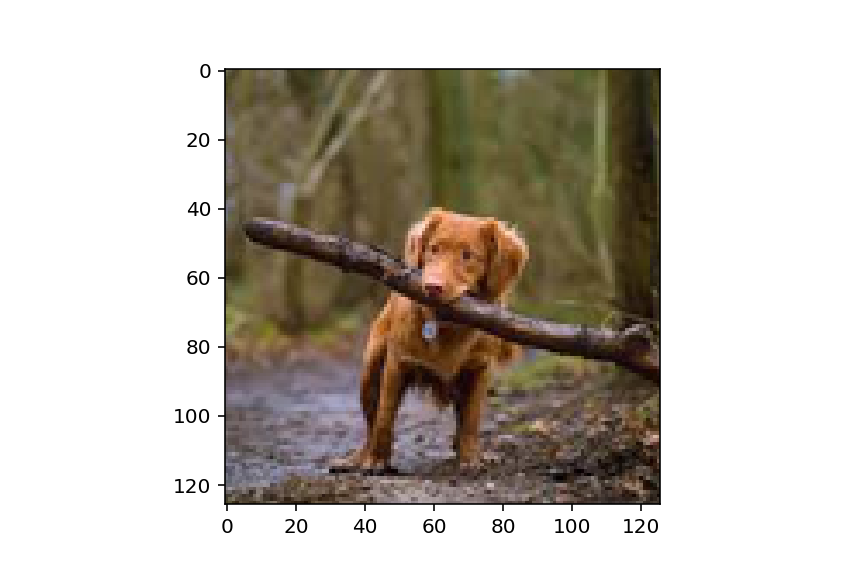

In [85]:
iNum = 102
reload(plt)
%matplotlib notebook
plt.figure()
plt.imshow(allImages[iNum])
plt.figure()
plt.imshow(rImages[iNum])
plt.figure()
plt.imshow(bImages[iNum])
plt.figure()
plt.imshow(gImages[iNum])
plt.figure()
plt.imshow(gsImages[iNum])

# Running Filtered Images through model

In [35]:
def evalNN(imageList, layerNum = 0):
    batch_t = []
    i = 0
    for img in imageList:
        img_t = transform(img)
        batch_t.append(torch.unsqueeze(img_t, 0)) # batch_t is set of transformed image
    
    l = list(model.children())
    delete = len(l[0]) - layerNum -1 #number of truncating layers from the model
    print("Layer:", layerNum)
    print("Deleted", delete)
    nn_trunc = nn.Sequential(*l[0][:len(l[0])-delete])
    nn_trunc.eval()
    
    out = []
    for i in range(2*num):
        out.append(nn_trunc(batch_t[i]))
    print(out[0].shape)
    print(out[-1].shape)
    
    arr = []
    for i in range(2 * num):
        arr.append(out[i].view(1, out[i].shape[0]*out[i].shape[1]*out[i].shape[2]*out[i].shape[3]))
    
    import numpy as np
    x = arr[0].detach().numpy()
    for nparr in arr[1:]:
        x = np.vstack([x, nparr.detach().numpy()])
    
    pca = PCA(n_components=50)
    pca_result = pca.fit_transform(x)
    
    tsne = TSNE(n_components=3, verbose=0, perplexity=40, n_iter=300)
    return tsne.fit_transform(pca_result)

# Running Each Image through the Neural Net

In [36]:
redEval_3 = evalNN(rImages, layerNum=3)
redEval_6 = evalNN(rImages, layerNum=6)
redEval_8 = evalNN(rImages, layerNum=8)
redEval_10 = evalNN(rImages, layerNum=10)
print(redEval_3.shape,redEval_6.shape,redEval_8.shape,redEval_10.shape)

Layer: 3
Deleted 9
torch.Size([1, 192, 27, 27])
torch.Size([1, 192, 27, 27])
Layer: 6
Deleted 6
torch.Size([1, 384, 13, 13])
torch.Size([1, 384, 13, 13])
Layer: 8
Deleted 4
torch.Size([1, 256, 13, 13])
torch.Size([1, 256, 13, 13])
Layer: 10
Deleted 2
torch.Size([1, 256, 13, 13])
torch.Size([1, 256, 13, 13])
(460, 3) (460, 3) (460, 3) (460, 3)


In [37]:
greenEval_3 = evalNN(gImages, layerNum=3)
greenEval_6 = evalNN(gImages, layerNum=6)
greenEval_8 = evalNN(gImages, layerNum=8)
greenEval_10 = evalNN(gImages, layerNum=10)
print(redEval_3.shape,redEval_6.shape,redEval_8.shape,redEval_10.shape)

Layer: 3
Deleted 9
torch.Size([1, 192, 27, 27])
torch.Size([1, 192, 27, 27])
Layer: 6
Deleted 6
torch.Size([1, 384, 13, 13])
torch.Size([1, 384, 13, 13])
Layer: 8
Deleted 4
torch.Size([1, 256, 13, 13])
torch.Size([1, 256, 13, 13])
Layer: 10
Deleted 2
torch.Size([1, 256, 13, 13])
torch.Size([1, 256, 13, 13])
(460, 3) (460, 3) (460, 3) (460, 3)


In [38]:
blueEval_3 = evalNN(bImages, layerNum=3)
blueEval_6 = evalNN(bImages, layerNum=6)
blueEval_8 = evalNN(bImages, layerNum=8)
blueEval_10 = evalNN(bImages, layerNum=10)
print(redEval_3.shape,redEval_6.shape,redEval_8.shape,redEval_10.shape)

Layer: 3
Deleted 9
torch.Size([1, 192, 27, 27])
torch.Size([1, 192, 27, 27])
Layer: 6
Deleted 6
torch.Size([1, 384, 13, 13])
torch.Size([1, 384, 13, 13])
Layer: 8
Deleted 4
torch.Size([1, 256, 13, 13])
torch.Size([1, 256, 13, 13])
Layer: 10
Deleted 2
torch.Size([1, 256, 13, 13])
torch.Size([1, 256, 13, 13])
(460, 3) (460, 3) (460, 3) (460, 3)


In [39]:
gsEval_3 = evalNN(gsImages, layerNum=3)
gsEval_6 = evalNN(gsImages, layerNum=6)
gsEval_8 = evalNN(gsImages, layerNum=8)
gsEval_10 = evalNN(gsImages, layerNum=10)
print(redEval_3.shape,redEval_6.shape,redEval_8.shape,redEval_10.shape)

Layer: 3
Deleted 9
torch.Size([1, 192, 27, 27])
torch.Size([1, 192, 27, 27])
Layer: 6
Deleted 6
torch.Size([1, 384, 13, 13])
torch.Size([1, 384, 13, 13])
Layer: 8
Deleted 4
torch.Size([1, 256, 13, 13])
torch.Size([1, 256, 13, 13])
Layer: 10
Deleted 2
torch.Size([1, 256, 13, 13])
torch.Size([1, 256, 13, 13])
(460, 3) (460, 3) (460, 3) (460, 3)


# Plot Comparison of Different Filters (Red, Green, Blue, GrayScale)

In [40]:
reload(plt)
%matplotlib notebook
def plot3DScatter(r,g,b,gs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x,y,z = r[:,0],r[:,1],r[:,2]
    ax.scatter(x,y,z,color='red')

    x,y,z = g[:,0],g[:,1],g[:,2]
    ax.scatter(x,y,z,color='green')
    
    x,y,z = b[:,0],b[:,1],b[:,2]
    ax.scatter(x,y,z,color='blue')
    
    x,y,z = gs[:,0],gs[:,1],gs[:,2]
    ax.scatter(x,y,z,color='grey')

In [41]:
import plotly.graph_objects as go
def plotly3DScatter(r,g,b,gs, labels = ["Red Filter","Green Filter", "Blue Filter", "GreyScale Filter"]):
    opacity = .5
    x,y,z = r[:,0],r[:,1],r[:,2]
    scatter1 = go.Scatter3d(x=x, y=y, z=z, mode='markers',
                            marker=dict(color='red',opacity=opacity), name=labels[0])
    
    x,y,z = g[:,0],g[:,1],g[:,2]
    scatter2 = go.Scatter3d(x=x, y=y, z=z, mode='markers',
                            marker=dict(color='green',opacity=opacity), name=labels[1])
    
    x,y,z = b[:,0],b[:,1],b[:,2]
    scatter3 = go.Scatter3d(x=x, y=y, z=z, mode='markers',
                            marker=dict(color='blue',opacity=opacity), name=labels[2])
    
    x,y,z = gs[:,0],gs[:,1],gs[:,2]
    scatter4 = go.Scatter3d(x=x, y=y, z=z, mode='markers',
                            marker=dict(color='grey',opacity=opacity), name=labels[3])
    
    fig = go.Figure(data=[scatter1,scatter2,scatter3,scatter4])
    fig.show()

In [42]:
plotly3DScatter(redEval_3,greenEval_3,blueEval_3,gsEval_3)
plotly3DScatter(redEval_6,greenEval_6,blueEval_6,gsEval_6)
plotly3DScatter(redEval_8,greenEval_8,blueEval_8,gsEval_8)
plotly3DScatter(redEval_10,greenEval_10,blueEval_10,gsEval_10)

# K-Means Clustering and Plot

In [159]:
from sklearn.cluster import KMeans
from ipywidgets import Output, VBox
from IPython.display import HTML

def cluster_kmeans(layerToLoad, clusterNum):
    dogs = np.loadtxt('./output/dog_layer' + str(layerToLoad) + '.txt')
    buildings = np.loadtxt('./output/building_layer' + str(layerToLoad) + '.txt')
    combined = np.vstack([dogs,buildings])

    kmeans_result = KMeans(n_clusters=clusterNum).fit_predict(combined)

    dogs_classification = kmeans_result[:len(combined)//2]
    buildings_classification = kmeans_result[len(combined)//2:]

    label, num = np.unique(dogs_classification, return_counts=True)
    dog_breakdown = dict(zip(label, num))

    label, num = np.unique(buildings_classification, return_counts=True)
    buidling_breakdown = dict(zip(label, num))
    
    return kmeans_result, combined, dog_breakdown, buidling_breakdown

def plot_cluster(layerToLoad, clusterNum=4):
    kmeans_result, combined, dog_breakdown, buidling_breakdown = cluster_kmeans(layerToLoad, clusterNum)
    combined = np.insert(combined, 3, list(range(0,len(combined))), axis=1)
    
    set_0 = combined[np.nonzero(kmeans_result == 0)]
    set_1 = combined[np.nonzero(kmeans_result == 1)]
    set_2 = combined[np.nonzero(kmeans_result == 2)]
    set_3 = combined[np.nonzero(kmeans_result == 3)]
    
    plotly3DScatter(set_0,set_1,set_2,set_3, labels = ["Cluster 0","Cluster 1", "Cluster 2", "Cluster 3"])
    
import plotly.graph_objects as go
def plotly3DScatter(r,g,b,gs, labels = ["Red Filter","Green Filter", "Blue Filter", "GreyScale Filter"]):
    opacity = .5
    myfunc = lambda inum: "Image Num: " + str(int(inum))
    transform = lambda vec: list(np.vectorize(myfunc)(vec))
    x,y,z,num = r[:,0],r[:,1],r[:,2], transform(r[:,3])
    
    scatter1 = go.Scatter3d(x=x, y=y, z=z, mode='markers',
                            marker=dict(color='red',opacity=opacity), name=labels[0], hovertext=num, hoverinfo="text")
    
    x,y,z,num = g[:,0],g[:,1],g[:,2], transform(g[:,3])
    scatter2 = go.Scatter3d(x=x, y=y, z=z, mode='markers',
                            marker=dict(color='green',opacity=opacity), name=labels[1], hovertext=num, hoverinfo="text")
    
    x,y,z,num = b[:,0],b[:,1],b[:,2], transform(b[:,3])
    scatter3 = go.Scatter3d(x=x, y=y, z=z, mode='markers',
                            marker=dict(color='blue',opacity=opacity), name=labels[2], hovertext=num, hoverinfo="text")
    
    x,y,z,num = gs[:,0],gs[:,1],gs[:,2], transform(gs[:,3])
    scatter4 = go.Scatter3d(x=x, y=y, z=z, mode='markers',
                            marker=dict(color='grey',opacity=opacity), name=labels[3], hovertext=num, hoverinfo="text")
    
    fig = go.FigureWidget(data=[scatter1,scatter2,scatter3,scatter4])
    
    
    def update_point(trace, points, selector):
        print(points.point_inds)


    fig.data[0].on_click(update_point)

    fig.show()

In [160]:
plot_cluster(3)
plot_cluster(6)
plot_cluster(8)
plot_cluster(10)

<IPython.core.display.Javascript object>


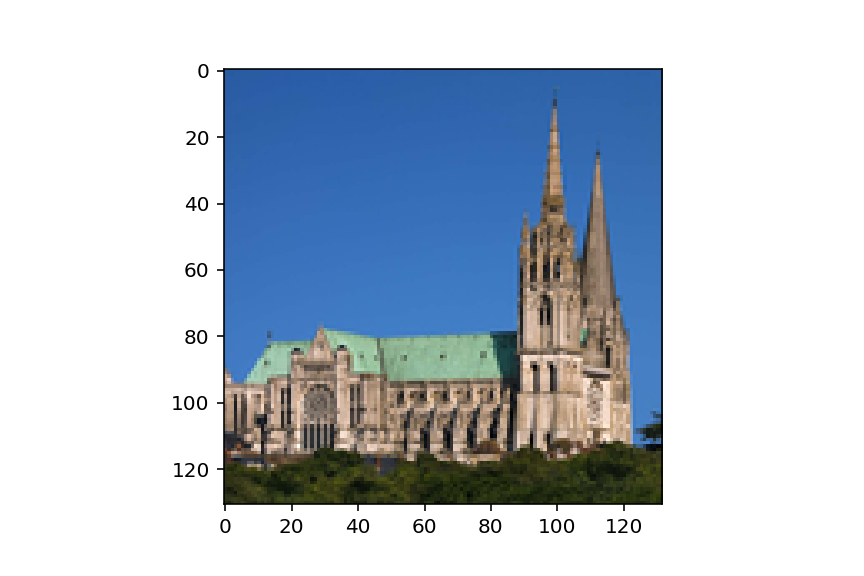

interactive(children=(IntSlider(value=0, description='x', max=459), Output()), _dom_classes=('widget-interact'…

interactive(children=(Text(value='0', description='x', placeholder='Type an image number'), Output()), _dom_cl…

In [158]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

reload(plt)
%matplotlib notebook
plt.figure()

def f1(x):
    text.value = str(x)
    plt.imshow(allImages[x%num*2])

def f2(x):
    if x.isdigit():
        x = int(x)
        slider.value = x
        plt.imshow(allImages[x%num*2])

slider = widgets.IntSlider(min=0, max=num*2-1, step=1, value=0)
text = widgets.Text(value="0", placeholder='Type an image number')
interact(f1, x=slider);
interact(f2, x=text);